In [10]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [11]:
for layer in model.layers:
    print(layer.name,layer)

input_2 <keras.engine.topology.InputLayer object at 0x7fb3de51d518>
block1_conv1 <keras.layers.convolutional.Conv2D object at 0x7fb3de51d828>
block1_conv2 <keras.layers.convolutional.Conv2D object at 0x7fb3de51d588>
block1_pool <keras.layers.pooling.MaxPooling2D object at 0x7fb3de51df28>
block2_conv1 <keras.layers.convolutional.Conv2D object at 0x7fb3de526ba8>
block2_conv2 <keras.layers.convolutional.Conv2D object at 0x7fb3de53cc88>
block2_pool <keras.layers.pooling.MaxPooling2D object at 0x7fb3de4cea58>
block3_conv1 <keras.layers.convolutional.Conv2D object at 0x7fb3de58f048>
block3_conv2 <keras.layers.convolutional.Conv2D object at 0x7fb3de4f6710>
block3_conv3 <keras.layers.convolutional.Conv2D object at 0x7fb3de48ef28>
block3_pool <keras.layers.pooling.MaxPooling2D object at 0x7fb3de4b9128>
block4_conv1 <keras.layers.convolutional.Conv2D object at 0x7fb3de451400>
block4_conv2 <keras.layers.convolutional.Conv2D object at 0x7fb3de467dd8>
block4_conv3 <keras.layers.convolutional.Conv2D

In [12]:
dict([(layer.name,layer)]) #last entry

{'block5_pool': <keras.layers.pooling.MaxPooling2D at 0x7fb3de38e940>}

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [14]:

# The call to `gradients` returns a list of tensors (of size 1 in this case)# The ca 
# hence we only keep the first element -- which is a tensor.
grads = K.gradients(loss, model.input)[0]

In [15]:
# We add 1e-5 before dividing so as to avoid accidentally dividing by 0.
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [16]:
iterate = K.function([model.input], [loss, grads])

# Let's test it:
import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [17]:
# We start from a gray image with some noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

# Run gradient ascent for 40 steps
step = 1.  # this is the magnitude of each gradient update
for i in range(40):
    # Compute the loss value and gradient value
    loss_value, grads_value = iterate([input_img_data])
    # Here we adjust the input image in the direction that maximizes the loss
    input_img_data += grads_value * step

In [18]:
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [19]:
def generate_pattern(layer_name, filter_index, size=150):
    # Build a loss function that maximizes the activation
    # of the nth filter of the layer considered.
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # Compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, model.input)[0]

    # Normalization trick: we normalize the gradient
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # This function returns the loss and grads given the input picture
    iterate = K.function([model.input], [loss, grads])
    
    # We start from a gray image with some noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # Run gradient ascent for 40 steps
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

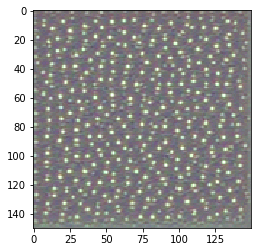

In [20]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

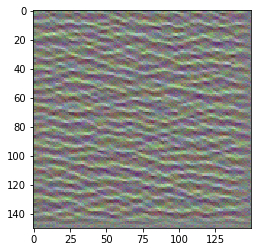

In [27]:
plt.imshow(generate_pattern('block3_conv1', 1))
plt.show()

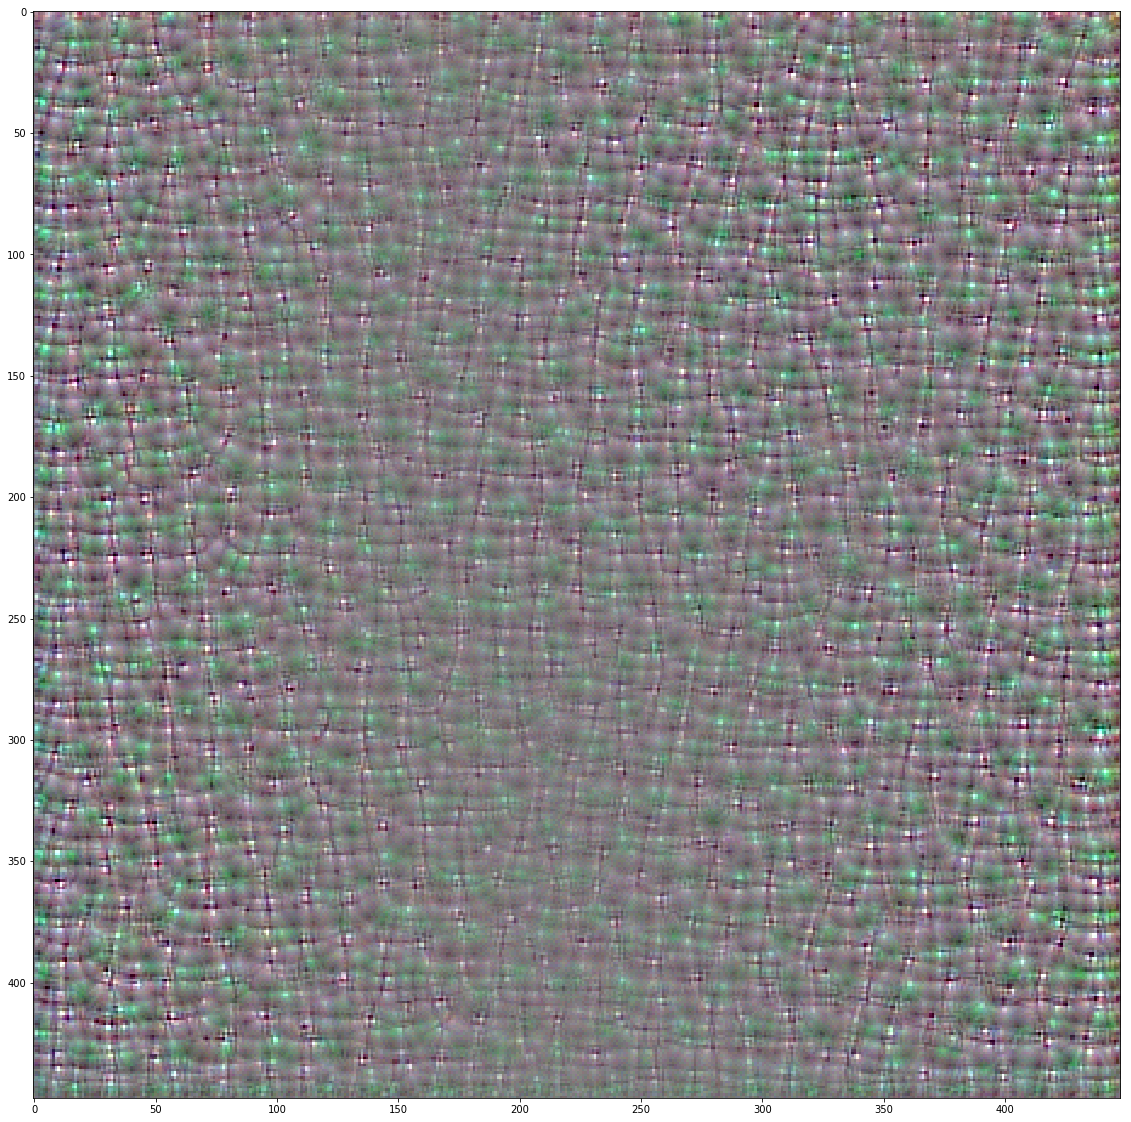

In [23]:
plt.figure(figsize=(20,20))
plt.imshow(generate_pattern('block4_conv1', 10,size=448))
plt.show()

block4_conv1


/home/ania/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


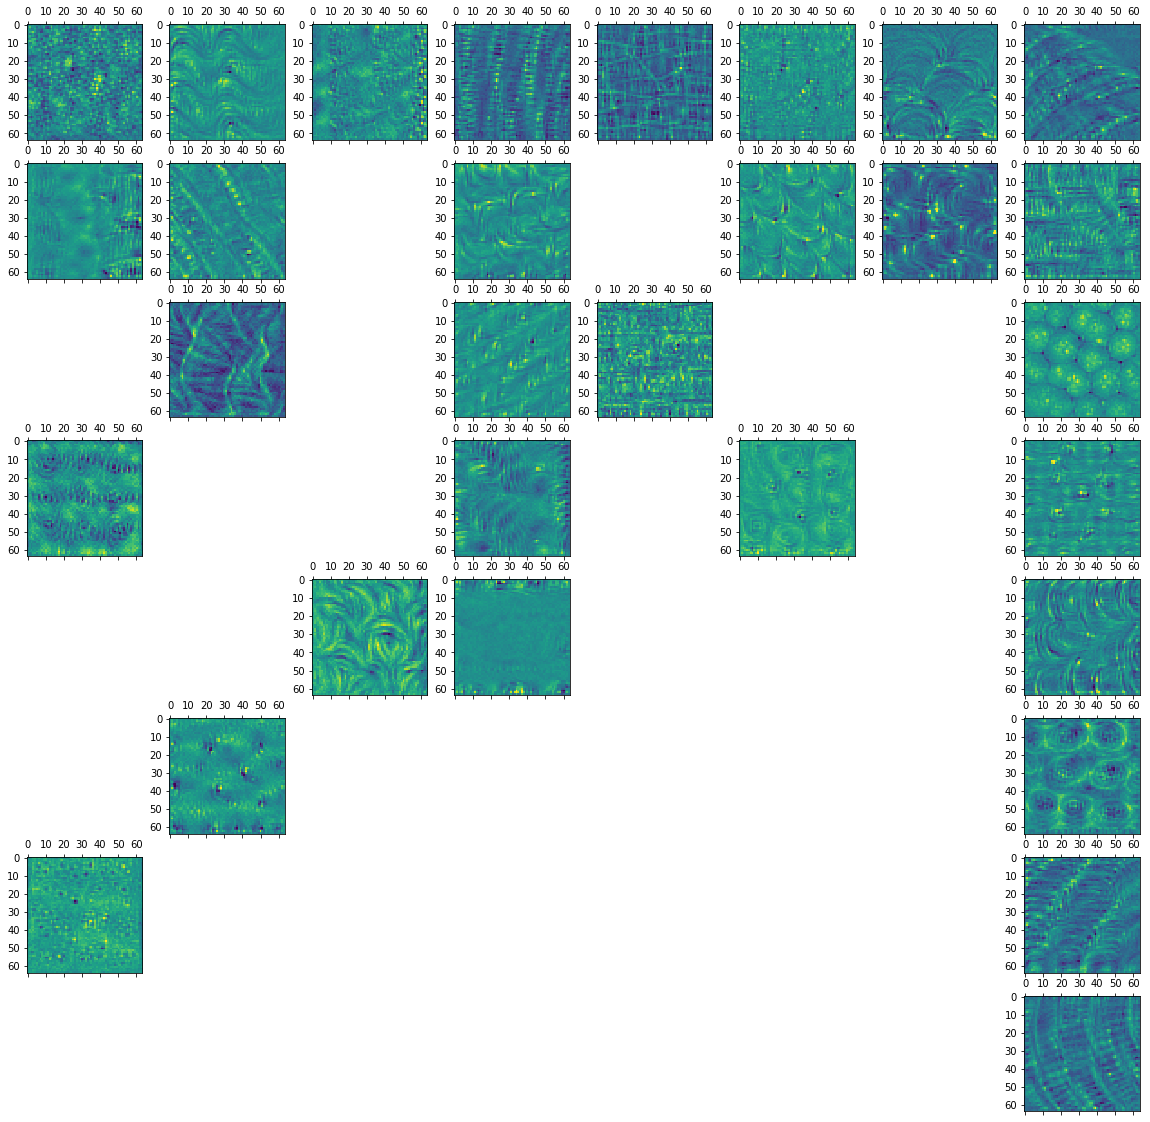

In [50]:
%matplotlib inline
for layer_name in ['block4_conv1']: #['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5
    print(layer_name)
    # This a empty (black) image where we will store our results.
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))


    plt.figure(figsize=(20,20))
#     for i in range(32): #activation_layer_size


#         ax=plt.subplot(4,8,i+1,xticks=[],yticks=[])  # just up to 32 filter for each layer,activation_layer_size//8
#         #visualize(imgs[i],ax)
#         ax.matshow(activation_layer_weight[0,:,:,0,i],cmap='viridis')  #color channel batch filter weight*height * color channel * output chanel
#         label=activation_layer_name+str(i)
#         #print(label)
#         position_=ax.set_title(label) 
#         position_.set_position([0.5,1.2])
#         #print(i)
#     plt.show()    
    
    
    for i in range(8):  # iterate over the rows of our results grid
        for j in range(8):  # iterate over the columns of our results grid
            # Generate the pattern for filter `i + (j * 8)` in `layer_name`
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)
            #print(filter_img.shape)
            ax=plt.subplot(8,8,(j+1)*(i+1),xticks=[],yticks=[])
            ax.matshow(filter_img[:,:,0]) #,cmap='viridis')

            # Put the result in the square `(i, j)` of the results grid
#             horizontal_start = i * size + i * margin
#             horizontal_end = horizontal_start + size
#             vertical_start = j * size + j * margin
#             vertical_end = vertical_start + size
#             results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img
#             plt.imshow(filter_img)
#             plt.show()
            
            
    # Display the results grid
#     plt.figure(figsize=(20, 20))
#     plt.imshow(results)
    plt.show()
